# Analysis of N-gram Regression Model Results

### 1. Import Libraries and Configuration

First, we import all the necessary libraries for data manipulation, loading artefacts, and plotting. We also import the project's configuration file to access global variables like file paths and column names.

In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from scipy.stats import spearmanr
import sys
import os

# Add src to the Python path to import the config file
sys.path.append('src')
from config import (
    DATA_FILE, TARGET_PROPERTIES, FOLD_COLUMN, FOLDS, VH_SEQUENCE_COL,
    VL_SEQUENCE_COL, HC_SUBTYPE_COL, ARTEFACTS_DIR
)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

### 2. Load Data and Transformers

Next, we load the main dataset and the pre-fitted transformers (vectorizers and one-hot encoder) that were created during the feature engineering phase. These are essential for generating the feature vectors for our test data.

In [4]:
try:
    df = pd.read_csv(DATA_FILE)
    vectorizer_vh = joblib.load(ARTEFACTS_DIR / 'vectorizer_vh.joblib')
    vectorizer_vl = joblib.load(ARTEFACTS_DIR / 'vectorizer_vl.joblib')
    encoder_ohe = joblib.load(ARTEFACTS_DIR / 'encoder_ohe.joblib')
    print("Data and transformers loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the data and artefact files exist.")

Data and transformers loaded successfully.


### 3. Generate Predictions with Uncertainty

This is the core function for our analysis. For a given target property, it performs the following steps:
1.  Loads the corresponding trained model ensembles.
2.  Iterates through each of the 5 cross-validation folds.
3.  For each fold, it identifies the test set, transforms its features, and generates predictions using the appropriate ensemble of bootstrap models.
4.  It calculates the mean and standard deviation of the predictions from the ensemble for each data point in the test set.
5.  It collects and returns the true values, predicted means, and predicted standard deviations for all data points across all folds.

In [8]:
def get_predictions_with_uncertainty(df, target):
    """
    Generates predictions for a target property across all 5 CV folds.
    
    Args:
        df (pd.DataFrame): The full dataset.
        target (str): The name of the target property.
        
    Returns:
        tuple: A tuple containing (y_true_all, y_pred_mean_all, y_pred_std_all).
    """
    try:
        all_fold_ensembles = joblib.load(ARTEFACTS_DIR / f'models_{target}.joblib')
    except FileNotFoundError:
        print(f"Models for {target} not found. Please run the training script first.")
        return None, None, None

    df_target = df.dropna(subset=[target]).copy()
    
    y_true_all = []
    y_pred_mean_all = []
    y_pred_std_all = []

    for fold_i in FOLDS:
        test_mask = (df_target[FOLD_COLUMN] == fold_i)
        df_test = df_target[test_mask]
        
        if df_test.empty:
            continue

        y_true = df_test[target].values
        
        # Transform features
        X_test_vh = vectorizer_vh.transform(df_test[VH_SEQUENCE_COL])
        X_test_vl = vectorizer_vl.transform(df_test[VL_SEQUENCE_COL])
        X_test_ohe = encoder_ohe.transform(df_test[[HC_SUBTYPE_COL]])
        X_test = hstack([X_test_vh, X_test_vl, X_test_ohe], format='csr')

        # Get the ensemble for this fold
        ensemble_models = all_fold_ensembles[fold_i]
        
        # Generate predictions from each model in the ensemble
        fold_predictions = [model.predict(X_test) for model in ensemble_models]
        
        # Calculate mean and std dev across the ensemble predictions
        y_pred_mean = np.mean(fold_predictions, axis=0)
        y_pred_std = np.std(fold_predictions, axis=0)
        
        y_true_all.extend(y_true)
        y_pred_mean_all.extend(y_pred_mean)
        y_pred_std_all.extend(y_pred_std)
        
    return np.array(y_true_all), np.array(y_pred_mean_all), np.array(y_pred_std_all)

### 4. Process All Targets and Store Results

Now, we loop through all the target properties defined in our configuration. For each one, we call the function above to get the true values and predictions, and we store these results in a dictionary for later use.

In [9]:
results = {}
for target in TARGET_PROPERTIES:
    print(f"Processing {target}...")
    y_true, y_pred_mean, y_pred_std = get_predictions_with_uncertainty(df, target)
    if y_true is not None:
        results[target] = {
            'true': y_true,
            'pred_mean': y_pred_mean,
            'pred_std': y_pred_std
        }
print("All targets processed.")

Processing Titer...
Processing HIC...
Processing PR_CHO...
Processing Tm2...
Processing AC-SINS_pH7.4...
All targets processed.


### 5. Visualize Results: True vs. Predicted with Uncertainty

Finally, we create the scatter plots. For each target property, we plot the true values against the mean of the predicted values. The vertical error bars on each point represent the standard deviation of the predictions from the bootstrap ensemble, giving us a visual sense of the model's confidence for each prediction. We also calculate and display the Spearman rank correlation, which is our primary evaluation metric.

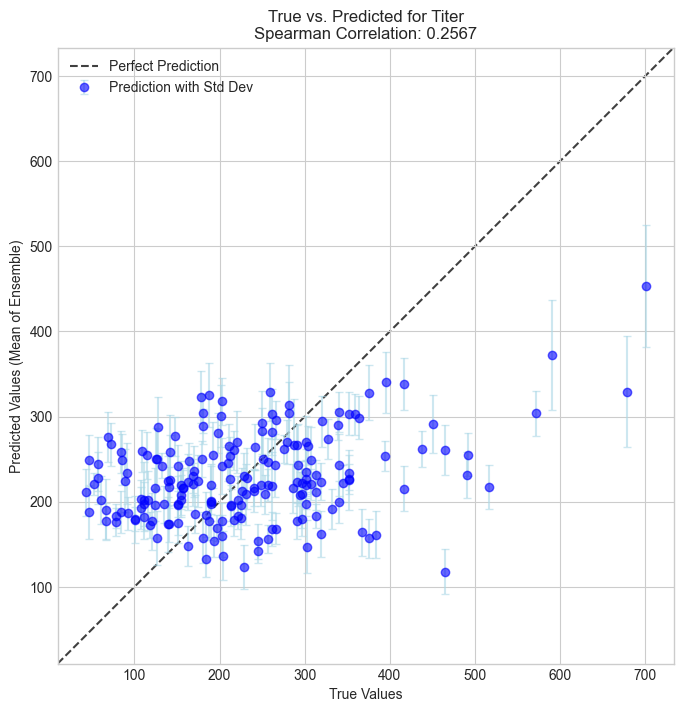

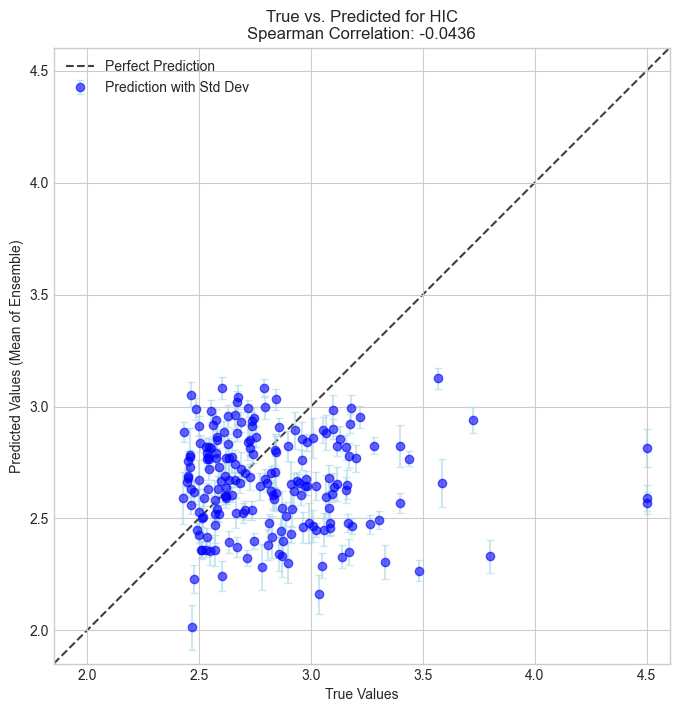

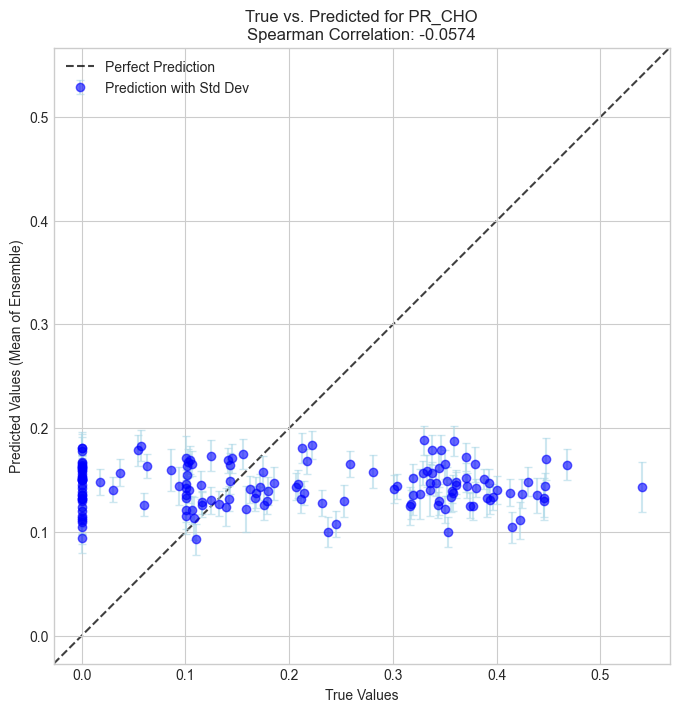

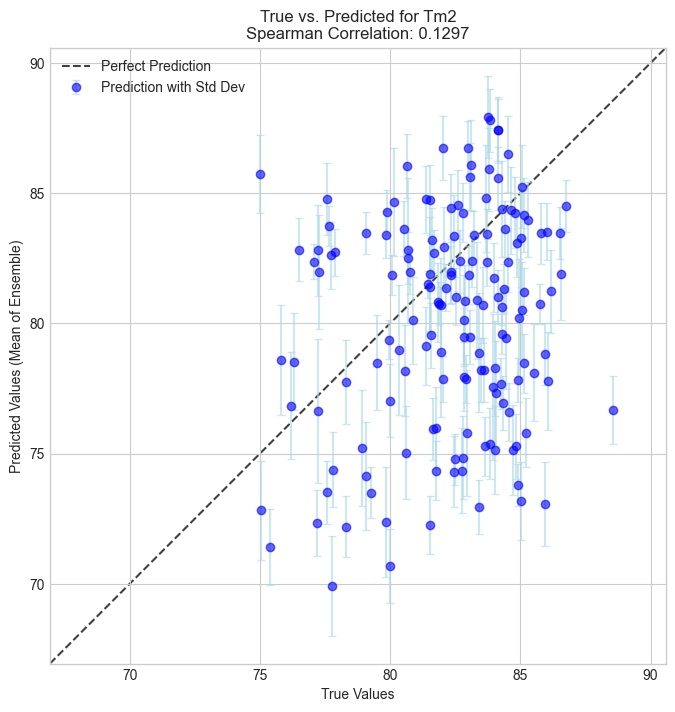

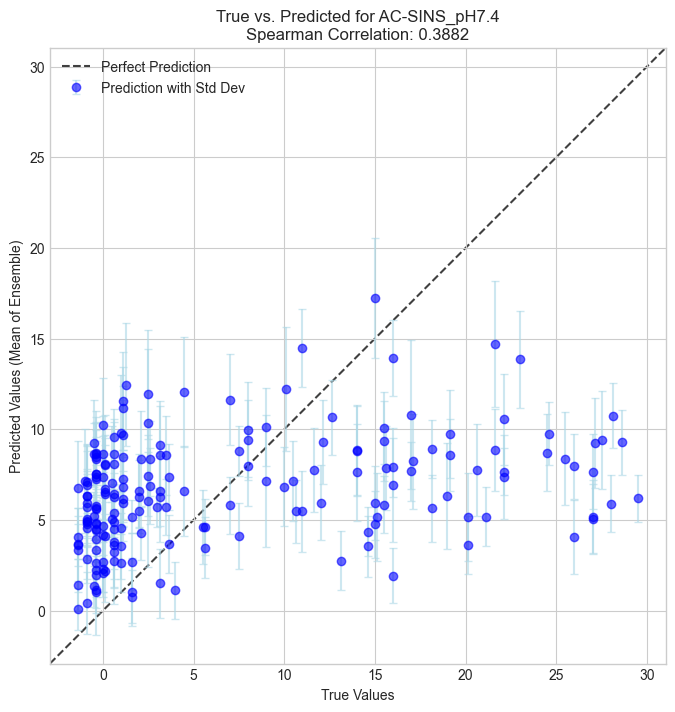

In [10]:
for target, data in results.items():
    y_true = data['true']
    y_pred_mean = data['pred_mean']
    y_pred_std = data['pred_std']
    
    # Calculate Spearman correlation
    corr, _ = spearmanr(y_true, y_pred_mean)
    
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot with error bars
    plt.errorbar(y_true, y_pred_mean, yerr=y_pred_std, fmt='o', color='blue', ecolor='lightblue', capsize=3, alpha=0.6, label='Prediction with Std Dev')
    
    # Plot the 'perfect prediction' line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),
        np.max([plt.xlim(), plt.ylim()]),
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Perfect Prediction')
    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.title(f'True vs. Predicted for {target}\nSpearman Correlation: {corr:.4f}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values (Mean of Ensemble)')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()